In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# **Loading and preparing our generated dataframe**

In [2]:
import pandas as pd
df = pd.read_csv('/content/gdrive/My Drive/Projet NBA/Datasets/df.csv')

# Select the variables to work with
dataset = df[['Player Name','Period Grouped', 'Total Seconds Remaining', 'Shot Distance', 'Action Type Grouped', 'on_fire', 'Shot_Team', 'Shot Type', 'X Location', 'Y Location',
              'Season Type', '2PT Field Goal_accuracy', '3PT Field Goal_accuracy', 'height', 'weight', 'age', 'W_PCT', 'Shot Made Flag']]
dataset_i = df[['Period Grouped', 'Total Seconds Remaining', 'Shot Distance', 'Action Type Grouped', 'on_fire', 'Shot_Team', 'Shot Type', 'X Location', 'Y Location',
              'Season Type', '2PT Field Goal_accuracy', '3PT Field Goal_accuracy', 'height', 'weight', 'age', 'W_PCT', 'Shot Made Flag']]

# Separate variables from target
X = dataset_i.drop('Shot Made Flag', axis=1)
y = dataset_i['Shot Made Flag']

# Balancing Data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Separating into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_save = X_test
y_test_save = y_test

# Get dummies for categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Standarization for numerical variables
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print('The train set has a shape:', X_train.shape)
print('The test set has a shape:', X_test.shape)

The train set has a shape: (190342, 29)
The test set has a shape: (47586, 29)


# **Models Training**

In [3]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## **Logistic Regression**

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state = 22)
params_lr  = {'solver': ['liblinear', 'lbfgs'], 'C': np.logspace(-4, 2, 9)}
gridcv_lr = GridSearchCV(lr, param_grid=params_lr, cv=5)

gridcv_lr.fit(X_train, y_train)
y_pred_lr = gridcv_lr.predict(X_test)

print('Best parameters:', gridcv_lr.best_params_)
print('Accuracy:', accuracy_score(y_test, y_pred_lr))
print(f"Report:\n{classification_report(y_test, y_pred_lr)}")
print(f"Confusion matrix:\n{pd.crosstab(y_test, y_pred_lr)}")

Best parameters: {'C': 0.0031622776601683794, 'solver': 'liblinear'}
Accuracy: 0.6310259319968058
Report:
              precision    recall  f1-score   support

           0       0.61      0.70      0.66     23692
           1       0.66      0.56      0.60     23894

    accuracy                           0.63     47586
   macro avg       0.63      0.63      0.63     47586
weighted avg       0.63      0.63      0.63     47586

Confusion matrix:
col_0               0      1
Shot Made Flag              
0               16670   7022
1               10536  13358


## **Random Forest**

In [ ]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print(f"Report:\n{classification_report(y_test, y_pred_rf)}")
print(f"Confusion matrix:\n{pd.crosstab(y_test, y_pred_rf)}")

Accuracy: 0.6226200983482537
Report:
              precision    recall  f1-score   support

           0       0.61      0.68      0.64     23692
           1       0.64      0.57      0.60     23894

    accuracy                           0.62     47586
   macro avg       0.62      0.62      0.62     47586
weighted avg       0.62      0.62      0.62     47586

Confusion matrix:
col_0               0      1
Shot Made Flag              
0               16039   7653
1               10305  13589


## **Gradient Boosting Classifier**

In [ ]:
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_gb))
print(f"Report:\n{classification_report(y_test, y_pred_gb)}")
print(f"Confusion matrix:\n{pd.crosstab(y_test, y_pred_gb)}")

Accuracy: 0.6359853738494515
Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     23692
           1       0.68      0.53      0.59     23894

    accuracy                           0.64     47586
   macro avg       0.64      0.64      0.63     47586
weighted avg       0.64      0.64      0.63     47586

Confusion matrix:
col_0               0      1
Shot Made Flag              
0               17708   5984
1               11338  12556


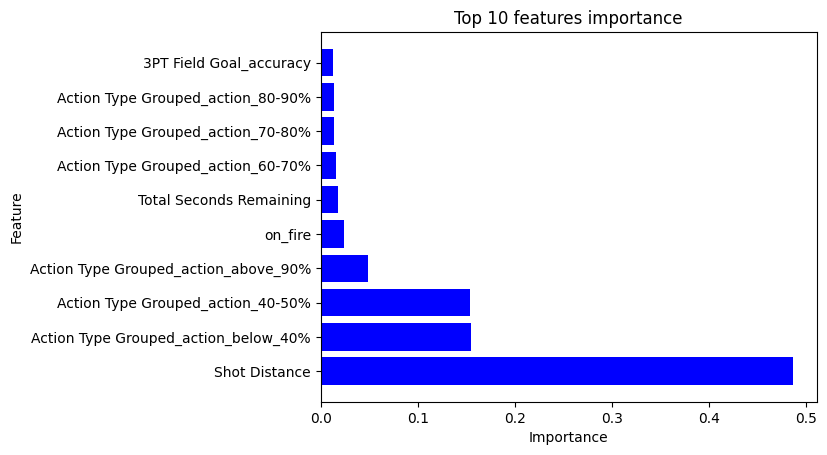

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

plt.barh(y=feature_importance['Feature'][:10], width=feature_importance['Importance'][:10], color='blue')

plt.title('Top 10 features importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## **Light GBM**

In [ ]:
lgb = lgb.LGBMClassifier(max_depth=11,  boosting_type='dart', n_estimators=500, n_jobs=-1)
lgb.fit(X_train, y_train)

y_pred_lgb = lgb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_lgb))
print(f"Report:\n{classification_report(y_test, y_pred_lgb)}")
print(f"Confusion matrix:\n{pd.crosstab(y_test, y_pred_lgb)}")

Accuracy: 0.6430252595301139
Report:
              precision    recall  f1-score   support

           0       0.62      0.75      0.68     23692
           1       0.68      0.54      0.60     23894

    accuracy                           0.64     47586
   macro avg       0.65      0.64      0.64     47586
weighted avg       0.65      0.64      0.64     47586

Confusion matrix:
col_0               0      1
Shot Made Flag              
0               17791   5901
1               11086  12808


## **XGBoost**

In [ ]:
xgb = XGBClassifier(n_estimators=500, learning_rate=0.01)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_xgb))
print(f"Report:\n{classification_report(y_test, y_pred_xgb)}")
print(f"Confusion matrix:\n{pd.crosstab(y_test, y_pred_xgb)}")

Accuracy: 0.6404194510990627
Report:
              precision    recall  f1-score   support

           0       0.61      0.75      0.67     23692
           1       0.68      0.53      0.60     23894

    accuracy                           0.64     47586
   macro avg       0.65      0.64      0.64     47586
weighted avg       0.65      0.64      0.64     47586

Confusion matrix:
col_0               0      1
Shot Made Flag              
0               17726   5966
1               11145  12749


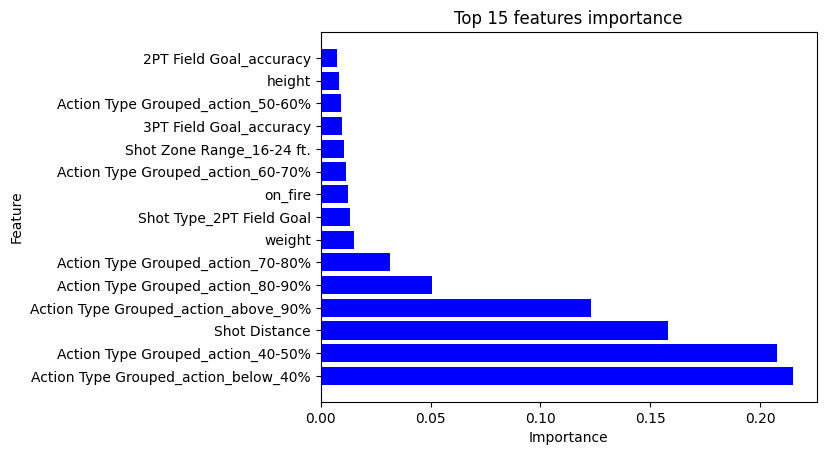

In [ ]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb.feature_importances_})
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

plt.barh(y=feature_importance['Feature'][:15], width=feature_importance['Importance'][:15], color='blue')

plt.title('Top 15 features importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# **Single Player Model**

## **Stephen Curry**

In [15]:
curry = dataset[dataset['Player Name']=='Stephen Curry']
curry = curry.drop(['Player Name', '2PT Field Goal_accuracy', '3PT Field Goal_accuracy', 'height', 'weight'], axis=1)

# Separate variables from target
X = curry.drop('Shot Made Flag', axis=1)
y = curry['Shot Made Flag']

# Balancing Data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Separating into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_save = X_test
y_test_save = y_test

# Get dummies for categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Standarization for numerical variables
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
from sklearn.preprocessing import StandardScaler
scaler_curry = StandardScaler()
X_train[numeric_cols] = scaler_curry.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_curry.transform(X_test[numeric_cols])

print('The train set has a shape:', X_train.shape)
print('The test set has a shape:', X_test.shape)

The train set has a shape: (10652, 25)
The test set has a shape: (2664, 25)


In [12]:
xgb_curry = XGBClassifier(n_estimators=500, learning_rate=0.01)
xgb_curry.fit(X_train, y_train)

y_pred_xgb_curry = xgb_curry.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_xgb_curry))
print(f"Report:\n{classification_report(y_test, y_pred_xgb_curry)}")
print(f"Confusion matrix:\n{pd.crosstab(y_test, y_pred_xgb_curry)}")

Accuracy: 0.6670420420420421
Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.66      1329
           1       0.67      0.68      0.67      1335

    accuracy                           0.67      2664
   macro avg       0.67      0.67      0.67      2664
weighted avg       0.67      0.67      0.67      2664

Confusion matrix:
col_0             0    1
Shot Made Flag          
0               875  454
1               433  902


In [7]:
import pickle
filename = '/content/gdrive/My Drive/Projet NBA/Datasets/curry_model.sav'
pickle.dump(xgb_curry, open(filename, 'wb'))

In [16]:
from pickle import dump
dump(scaler_curry, open('/content/gdrive/My Drive/Projet NBA/scaler_curry.pkl', 'wb'))

In [19]:
curry.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14101 entries, 19704 to 248526
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Period Grouped           14101 non-null  object 
 1   Total Seconds Remaining  14101 non-null  int64  
 2   Shot Distance            14101 non-null  int64  
 3   Action Type Grouped      14101 non-null  object 
 4   on_fire                  14101 non-null  int64  
 5   Shot_Team                14101 non-null  object 
 6   Shot Type                14101 non-null  object 
 7   X Location               14101 non-null  int64  
 8   Y Location               14101 non-null  int64  
 9   Season Type              14101 non-null  object 
 10  age                      14101 non-null  int64  
 11  W_PCT                    14101 non-null  float64
 12  Shot Made Flag           14101 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.5+ MB


## **LeBron James**

In [17]:
bron = dataset[dataset['Player Name']=='LeBron James']
bron = bron.drop(['Player Name', '2PT Field Goal_accuracy', '3PT Field Goal_accuracy', 'height', 'weight'], axis=1)

# Separate variables from target
X = bron.drop('Shot Made Flag', axis=1)
y = bron['Shot Made Flag']

# Balancing Data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Separating into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_save = X_test
y_test_save = y_test

# Get dummies for categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Standarization for numerical variables
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
from sklearn.preprocessing import StandardScaler
scaler_lebron = StandardScaler()
X_train[numeric_cols] = scaler_lebron.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler_lebron.transform(X_test[numeric_cols])

print('The train set has a shape:', X_train.shape)
print('The test set has a shape:', X_test.shape)

The train set has a shape: (16846, 25)
The test set has a shape: (4212, 25)


In [14]:
xgb_bron = XGBClassifier(n_estimators=500, learning_rate=0.01)
xgb_bron.fit(X_train, y_train)

y_pred_xgb_bron = xgb_bron.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_xgb_bron))
print(f"Report:\n{classification_report(y_test, y_pred_xgb_bron)}")
print(f"Confusion matrix:\n{pd.crosstab(y_test, y_pred_xgb_bron)}")

Accuracy: 0.686372269705603
Report:
              precision    recall  f1-score   support

           0       0.65      0.81      0.72      2108
           1       0.75      0.57      0.64      2104

    accuracy                           0.69      4212
   macro avg       0.70      0.69      0.68      4212
weighted avg       0.70      0.69      0.68      4212

Confusion matrix:
col_0              0     1
Shot Made Flag            
0               1702   406
1                915  1189


In [10]:
import pickle
filename = '/content/gdrive/My Drive/Projet NBA/Datasets/lebron_model.sav'
pickle.dump(xgb_bron, open(filename, 'wb'))

In [18]:
from pickle import dump
dump(scaler_lebron, open('/content/gdrive/My Drive/Projet NBA/scaler_lebron.pkl', 'wb'))

# **2 points model**

In [ ]:
two_point_dataset = dataset[dataset['Shot Type']=='2PT Field Goal']

# Separate variables from target
X = two_point_dataset.drop('Shot Made Flag', axis=1)
y = two_point_dataset['Shot Made Flag']

# Balancing Data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Separating into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_save = X_test
y_test_save = y_test

# Get dummies for categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Standarization for numerical variables
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.fit_transform(X_test[numeric_cols])

print('The train set has a shape:', X_train.shape)
print('The test set has a shape:', X_test.shape)

The train set has a shape: (147582, 51)
The test set has a shape: (36896, 51)


In [ ]:
xgb_2pt = XGBClassifier(n_estimators=500, learning_rate=0.01)
xgb_2pt.fit(X_train, y_train)

y_pred_xgb_2pt = xgb_2pt.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_xgb_2pt))
print('Report:', classification_report(y_test, y_pred_xgb_2pt))
print('Confusion matrix', pd.crosstab(y_test, y_pred_xgb_2pt))

Accuracy: 0.6502330875975716
Report:               precision    recall  f1-score   support

           0       0.63      0.74      0.68     18423
           1       0.69      0.56      0.61     18473

    accuracy                           0.65     36896
   macro avg       0.66      0.65      0.65     36896
weighted avg       0.66      0.65      0.65     36896

Confusion matrix col_0               0      1
Shot Made Flag              
0               13692   4731
1                8174  10299


# **3 points model**

In [ ]:
three_point_dataset = dataset[dataset['Shot Type']=='3PT Field Goal']

# Separate variables from target
X = three_point_dataset.drop('Shot Made Flag', axis=1)
y = three_point_dataset['Shot Made Flag']

# Balancing Data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

# Separating into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test_save = X_test
y_test_save = y_test

# Get dummies for categorical variables
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test = pd.get_dummies(X_test, columns=categorical_cols)

# Standarization for numerical variables
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.fit_transform(X_test[numeric_cols])

print('The train set has a shape:', X_train.shape)
print('The test set has a shape:', X_test.shape)

The train set has a shape: (34523, 48)
The test set has a shape: (8631, 48)


In [ ]:
xgb_3pt = XGBClassifier(n_estimators=500, learning_rate=0.01)
xgb_3pt.fit(X_train, y_train)

y_pred_xgb_3pt = xgb_3pt.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred_xgb_3pt))
print('Report:', classification_report(y_test, y_pred_xgb_3pt))
print('Confusion matrix', pd.crosstab(y_test, y_pred_xgb_3pt))

Accuracy: 0.559378982736647
Report:               precision    recall  f1-score   support

           0       0.56      0.58      0.57      4354
           1       0.56      0.53      0.55      4277

    accuracy                           0.56      8631
   macro avg       0.56      0.56      0.56      8631
weighted avg       0.56      0.56      0.56      8631

Confusion matrix col_0              0     1
Shot Made Flag            
0               2540  1814
1               1989  2288
